In [17]:
import os
from multiprocessing import Pool
from itertools import product

import numpy as np
from matplotlib import pyplot as plt

In [2]:
# Consts

METRIC_PARAMS = list(product(["l1", "l2"], ["score", "rank", "log_rank"])) + [("min_sum", "rank")]
# METRIC_PARAMS = [("min_sum", "rank")]

ITEM_FEATURES = {
    "score": "model_scores/scores_train.bin",
    "rank": "item_train_ranks.bin",
    "log_rank": "item_train_log_ranks.bin"
}

build_cmd_template = (
    "./RPG --mode base --baseSize 1000000 --trainQueries 1000 "
    "--base data/{dataset}/data/{itemFeatures} "
    "--outputGraph {graphPath} "
    "--relevanceVector {relevanceVector} --efConstruction {efConstruction} --M 8 "
    "--metric {metricType}"
)

search_cmd_template = (
    "./RPG --mode query --baseSize 1000000 --querySize 1000"
    " --query data/{dataset}/data/model_scores/scores_test.bin --inputGraph {inputGraph}"
    " --efSearch {efSearch} --topK 5 --output data/{dataset}/result.txt --gtQueries 1000 --gtTop 100 "
    "--groundtruth data/{dataset}/data/model_scores/groundtruth.bin"
)

In [3]:
# exp config

dataset = "collections"
efConstruction = 1000
relevanceVector = 100 # length of relevance vector
efSearchTicks = list(np.exp(np.linspace(np.log(10), np.log(10000), 31)).astype("int"))


In [4]:
def bench_cmd(cmd):
    res = {}
    with os.popen(cmd) as out:
        for line in out:
            for stat_name, prefix, suff_len in [
                ("relevance", "Average relevance: ", 1),
                ("recall", "Recall@5: ", 1),
                ("time", "Average query time: ", 3),
                ("evals", "Average number of model computations: ", 1)
            ]:
                if line.startswith(prefix):
                    res[stat_name] = float(line[len(prefix):-suff_len])
    return res

def measure_performance(graph, dataset, ef_ticks, n_threads=8):
    commands = []
    for ef in ef_ticks:
        commands.append(search_cmd_template.format(inputGraph=graph, dataset=dataset, efSearch=ef))
    pool = Pool(processes=n_threads)
    results = pool.map(bench_cmd, commands)
    return {
        "relevance": [res["relevance"] for res in results],
        "recall": [res["recall"] for res in results],
        "time": [res["time"] for res in results],
        "evals": [res["evals"] for res in results]
    }

In [18]:
# build graphs
for metric_type, feature_type in METRIC_PARAMS:
    # build graph
    graph_path = "data/{}/{}_{}_graph_rel{}ef{}.out".format(
        dataset, metric_type, feature_type,
        relevanceVector, efConstruction
    )
    if not os.path.isfile(graph_path):
        build_cmd = build_cmd_template.format(
            graphPath=graph_path,
            dataset=dataset,
            itemFeatures=ITEM_FEATURES[feature_type],
            efConstruction=efConstruction,
            relevanceVector=relevanceVector,
            metricType=metric_type
        )
        print(build_cmd)
        os.system(build_cmd)
        print("Graph for {} metric and {} features is built".format(metric_type, feature_type))
        print()


In [6]:
# measure performance of graphs
results = {}
for metric_type, feature_type in METRIC_PARAMS:
    graph_path = "data/{}/{}_{}_graph_rel{}ef{}.out".format(
        dataset, metric_type, feature_type,
        relevanceVector, efConstruction
    )
    graph_label = metric_type + " " + feature_type
    results[graph_label] = measure_performance(graph_path, dataset, efSearchTicks, n_threads=8)

In [15]:
def plot_results(results, x_data="evals", y_data="recall"):
    plt.xlabel(x_data)
    plt.ylabel(y_data)
    plt.xlim([1000, 20000])
    plt.ylim([0.8, 1])
    plt.xscale('log')
    for label, stats in results.items():
        plt.plot(stats[x_data], stats[y_data], label=label)
        plt.scatter(stats[x_data], stats[y_data], s=10)
    plt.legend()
    plt.show()

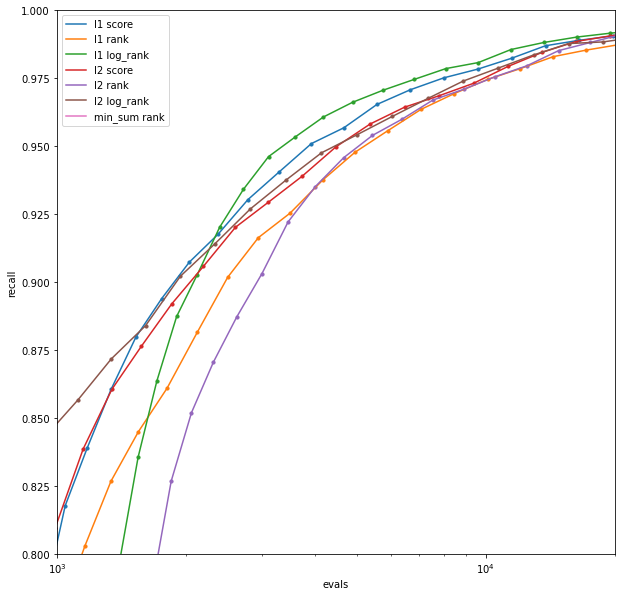

In [16]:
plt.figure(figsize=(10, 10))
plot_results(results)